In [1]:
import pygmt 
import pandas as pd 
import geopandas as gpd
from shapely.geometry import LineString
import xarray as xr 
import numpy as np
import warnings
import os
import glob
import sdc
from obspy import geodetics
warnings.filterwarnings('ignore')

In [2]:
# read the catalog
model = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_velocity_3_19.h5')
model = model.where(model.depth <= 10,drop=True)
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)
catalog.to_csv('TGR_hypoDD.csv',index=None)
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')
# read the gCAp
names=['x','y','longitude','latitude','depth','strike1','dip1','rake1','strike2','dip2','rake2',
       'magnitude','exp','plot_longitude','plot_latitude','name','label','time']
cap = pd.read_csv('TGR_data/gCAP/SanxiagCAP.gcmt',sep='\s+',skiprows=8,names=names)

In [3]:
topo = pygmt.datasets.load_earth_relief(resolution='01s',region=[110,111,30+40/60,31+20/60])

In [4]:
# read the geological data
TGR = gpd.read_file('TGR_data/geology/TGR.shp')
file = 'TGR_data/geology/H4909.gpkg'
H4909 = gpd.read_file(file, layer='strata').set_crs('EPSG:4326')
faults = gpd.read_file(file, layer='faults_main').set_crs('EPSG:4326')
# 清洗数据
geo = H4909.copy()
for i in range(len(H4909)):
    data = H4909.iloc[i]
    if data.geometry.is_empty:
        geo = geo.drop(index=i)
geo['name'] = geo['DSO']
geo_strata = {'Q':{'name':'Q','label':'Quaternary','color':'255/248/128'},
                'K':{'name':'K','label':'Cretaceous','color':'128/207/92'},
                'J':{'name':'J','label':'Jurassic','color':'181/204/227'},
                'P':{'name':'P','label':'Permian-Cambrian','color':'247/207/138'},
                'T':{'name':'T','label':'Triassic','color':'240/191/212'},
                'Pt':{'name':'Pt','label':'Precambrian','color':'240/143/117'}}


In [5]:
def get_profile(model,grid_topo,P1,spacing,wave='vp'):
    lon1,lat1,lon2,lat2 = P1
    points = pygmt.project(center=[lon1,lat1],endpoint=[lon2,lat2],generate=spacing[0], unit=True)
    ele = pygmt.grdtrack(points=points, grid=grid_topo,newcolname='elevation')
    ele.elevation = ele.elevation/1000

    depths = np.arange(0,model.depth.values.max()+spacing[1],spacing[1])
    #depths = model.depth.values
    for i,depth in enumerate(depths):
        grid = model[wave].interp(depth=depth,method='linear')
        track = pygmt.grdtrack(grid=grid,points=points,newcolname='vs')
        track['depth'] = [depth]*len(track)
        if i ==0:
            profile = track.copy()
        else:
            profile = pd.concat([profile,track])
    p_region = pygmt.info(data=profile[['p','depth']],per_column=True,spacing=spacing)
    p_grid = pygmt.xyz2grd(data=profile[['p','depth','vs']],spacing=spacing,region=p_region)
    return points,ele,p_grid,p_region,profile

In [6]:
def project_data(catalog,cap,P_A,width=15):
    lon1,lat1,lon2,lat2 = P_A
    reloc = pygmt.project(data=catalog[['longitude','latitude','depth']],
                      center=[lon1,lat1],endpoint=[lon2,lat2],
                      length='w',width=[-width,width],convention='pzq',unit=True)
    reloc.columns = ['p','z','q']
    meca = pygmt.project(data=cap[['longitude','latitude']],center=[lon1,lat1],endpoint=[lon2,lat2],width=None,unit=True)
    cap.loc[:,'p'] =  meca[2]
    cap.loc[:,'q'] = meca[3]
    meca = cap[abs(cap.q) <= width]
    return reloc,meca

In [7]:
def get_intersection(gdf,line):
    # 提取交点
    lon1,lat1,lon2,lat2 = line
    sline = LineString([(lon1,lat1),(lon2,lat2)])
    # 计算交点
    intersection_points = []
    names = []
    for i in range(len(gdf)):
        geom = gdf.iloc[i]
        intersection = geom.geometry.intersection(sline)
        #intersection = intersection.buffer(1)
        if not intersection.is_empty:
            try:
                names.append(geom['name'])
            except:
                names.append(i)
            intersection_points.append(intersection)

    # 转换为 GeoDataFrame
    intersection_gdf = gpd.GeoDataFrame(geometry=intersection_points)
    intersection_gdf['name'] = names
    return intersection_gdf
def get_line(gdf,line):
    intersection_gdf = get_intersection(gdf,line)
    lon_begin,lat_begin,lon_end,lat_end = line
    idx = 0
    geo_dict = {}
    data_points = []
    for i in range(len(intersection_gdf)):
        geom = intersection_gdf.iloc[i]
        geom_type = geom.geometry.geom_type
        data = []
        if geom_type == 'Point':
            xy_coords = list(geom.geometry.coords)
            lon1,lat1 = xy_coords[0][0:2]
            data_points.append([lon1,lat1])
            idx = idx+1
        if geom_type == 'LineString':
            xy_coords = list(geom.geometry.coords)
            lon1,lat1 = xy_coords[0][0:2]
            lon2,lat2 = xy_coords[1][0:2]
            data.append([lon1,lat1])
            data.append([lon2,lat2])
            dist = 0
            if lon_begin != lon1:
                dist0 = pygmt.project(center=[lon_begin,lat_begin],endpoint=[lon1,lat1],generate=0.01, unit=True)
                dist = dist0.p.values[-1]
            points = pygmt.project(center=[lon1,lat1],endpoint=[lon2,lat2],generate=0.01, unit=True)
            ele0 = pygmt.grdtrack(points=points, grid=topo,newcolname='elevation')
            idx = idx+1
            geo_dict[idx] = {'coords':data,'name':geom['name'],'track':ele0,'dist':dist}
        if geom_type == 'MultiLineString':
            for line in geom.geometry.geoms:
                xy_coords = list(line.coords)
                lon1,lat1 = xy_coords[0][0:2]
                lon2,lat2 = xy_coords[1][0:2]
                data.append([lon1,lat1])
                data.append([lon2,lat2])
                dist = 0
                if lon_begin != lon1:
                    dist0 = pygmt.project(center=[lon_begin,lat_begin],endpoint=[lon1,lat1],generate=0.01, unit=True)
                    dist = dist0.p.values[-1]
                points = pygmt.project(center=[lon1,lat1],endpoint=[lon2,lat2],generate=0.01, unit=True)
                ele0 = pygmt.grdtrack(points=points, grid=topo,newcolname='elevation')
                idx = idx+1
                geo_dict[idx] = {'coords':data,'name':geom['name'],'track':ele0,'dist':dist}
        if geom_type == 'MultiPolygon':
            print('Luo')
    if len(data_points)>0:
        data_points = pd.DataFrame(data_points,columns=['longitude','latitude'])
        data_points = pygmt.grdtrack(points=data_points, grid=topo,newcolname='elevation')
        track = pygmt.project(data=data_points,center=[lon_begin,lat_begin],endpoint=[lon_end,lat_end],length=None,width=None,unit=True)
        track.columns = ['x','y','z','p','q','r','s']
        geo_dict[idx] = {'coords':data_points,'name':'fault','track':track,'dist':0}
    return geo_dict
def plot_elevation(fig,fault,geo,line):
    lon1,lat1,lon2,lat2 = line
    points = pygmt.project(center=[lon1,lat1],endpoint=[lon2,lat2],generate=0.01, unit=True)
    elevation = pygmt.grdtrack(points=points, grid=topo,newcolname='elevation')

    gdf_fault = get_line(fault,line)
    gdf_fault = gdf_fault[list(gdf_fault)[0]]['track']
    gdf_fault = gdf_fault.sort_values(by='p')
    gdf_strata = get_line(geo,line)
    gdf_TGR = get_line(TGR,line)
    fig.plot(x=elevation.p,y=elevation.elevation/1000.,pen='0.5p',close='+y0', fill='gray')
    for i in list(gdf_strata):
        data = gdf_strata[i]
        ele,name,dist = data['track'],data['name'],data['dist']
        color = geo_strata[name]['color']
        fig.plot(x=ele.p+dist,y=ele.elevation/1000,pen=f'1p,{color}',close='+y0', fill=color)
        #print('x=',ele.p+dist,'y=',ele.elevation/1000,'name=',name,'color',color)
    for i in list(gdf_TGR):
        data = gdf_TGR[i]
        ele,dist = data['track'],data['dist']
        fig.plot(x=ele.p+dist,y=ele.elevation/1000,pen='1p,0/112/255')
        print('x=',ele.p.mean()+dist,'y=',ele.elevation.mean()/1000,'name=','river','color=','0/112/255')
    fig.plot(x=gdf_fault.p,y=gdf_fault.z/1000.,style='h0.1c',pen='0.3p',fill='red')
    print(gdf_fault)


In [8]:
def plot_meca(fig,cap,P1):
    lon1,lat1,lon2,lat2 = P1
    with pygmt.helpers.GMTTempFile() as temp_file:
        with open(temp_file.name, 'w') as f:
            for i in range(len(cap)):
                line = cap.iloc[i]
                f.write(f'{line.longitude} {line.latitude} {line.depth} {line.strike1} {line.dip1} {line.rake1} {line.magnitude}\n')
        with pygmt.clib.Session() as session:
            cmd = f'{temp_file.name} -Sa0.5 -Aa{lon1}/{lat1}/{lon2}/{lat2}/90/15/0/10 -Gblack -Q'
            session.call_module('coupe', cmd)

def plot_line(fig,line,ele,profile_region,label=['A1','A2'],fault_label=None):
    # plot elevation
    #fig.plot(x=ele.p, y=ele.elevation, pen='0.1p',close='+y0', fill='gray')
    plot_elevation(fig,faults,geo,line)
    fig.text(position='cTL',text=label[0],font='10p',offset='0.1c/0.c',no_clip=True)
    fig.text(position='cTR',text=label[1],font='10p',offset='-0.1c/0.c',no_clip=True)
    
    # label the fault
    if fault_label is not None:
        fig.plot(data=fault_label[['x','y','dx','dy']],style='V0.2c+b+h0.8',pen='0.4p',fill='black')
        fig.text(x=fault_label.x,y=fault_label.y,text=fault_label.name,font='7p',angle=45,justify='ML',offset='0.0c/0.5c',no_clip=True)

    # plot vp
    fig.shift_origin(yshift='-{}c'.format(map_height*zscale/xscale+0.0))
    fig.basemap(region=profile_region,projection='x{}c/-{}c'.format(xscale,zscale),frame=['xaf','yaf+lDepth(km)','Wsen'])
    fig.grdimage(grid=vp,cmap='velp.cpt')
    fig.grdcontour(grid=dwsp,interval=interval,limit=[interval,interval],pen='0.7p,white')
    fig.plot(x=reloc.p,y=reloc.z,style='c0.03c',fill='black',pen='0.1p')
    if len(meca) >=1:fig.plot(x=meca.p,y=meca.depth,style='a0.1i',fill='red',pen='0.1p')
    fig.colorbar(position='JMR+w0c/0.2c+o0.2c/0c+e',frame=['xaf'],cmap='velp.cpt')
    fig.text(position='cBL',text='Vp',offset='0.1c/0.1c',fill='white')

    # plot Vs
    fig.shift_origin(yshift='-{}c'.format(map_height*zscale/xscale+0.2))
    fig.basemap(region=profile_region,projection='x{}c/-{}c'.format(xscale,zscale),frame=['xaf','yaf+lDepth(km)','Wsen'])
    fig.grdimage(grid=vs,cmap='vels.cpt')
    fig.grdcontour(grid=dwss,interval=interval,limit=[interval,interval],pen='0.7p,white')

    fig.plot(x=reloc.p,y=reloc.z,style='c0.03c',fill='black',pen='0.1p')
    if len(meca) >=1:fig.plot(x=meca.p,y=meca.depth,style='a0.1i',fill='red',pen='0.1p')
    fig.colorbar(position='JMR+w0c/0.2c+o0.2c/0c+e',frame=['xaf'],cmap='vels.cpt')
    fig.text(position='cBL',text='Vs',offset='0.1c/0.1c',fill='white')

    # plot Vp/Vs
    fig.shift_origin(yshift='-{}c'.format(map_height*zscale/xscale+0.2))
    fig.basemap(region=profile_region,projection='x{}c/-{}c'.format(xscale,zscale),
                frame=['xaf+lDistance along the profile (km)','yaf+lDepth(km)','WSen'])
    fig.grdimage(grid=vp/vs,cmap='vpvs.cpt')
    fig.grdcontour(grid=dwsp,interval=interval,limit=[interval,interval],pen='0.7p,white')

    fig.plot(x=reloc.p,y=reloc.z,style='c0.03c',fill='black',pen='0.1p')
    if len(meca) >=1:fig.plot(x=meca.p,y=meca.depth,style='a0.1i',fill='red',pen='0.1p')
    fig.colorbar(position='JMR+w0c/0.2c+o0.2c/0c+e',frame=['xaf'],cmap='vpvs.cpt')
    fig.text(position='cBL',text='Vp/Vs',offset='0.1c/0.1c',fill='white')

In [9]:
# A1A2
lat_A1,lon_A1 = sdc.redist(xkm=-26,ykm=27,olat=31.0,olon=110.5,rota=0)
lat_A2,lon_A2 = sdc.redist(xkm=40,ykm=-21,olat=31.0,olon=110.5,rota=0)
P_A = [lon_A1,lat_A1,lon_A2,lat_A2]

# B1B2
lat_B1,lon_B1 = sdc.redist(xkm=-47,ykm=18,olat=31.0,olon=110.5,rota=0)
lat_B2,lon_B2 = sdc.redist(xkm=40,ykm=18,olat=31.0,olon=110.5,rota=0)
P_B = [lon_B1,lat_B1,lon_B2,lat_B2]
width = 3

# C1C2
lat_C1,lon_C1 = sdc.redist(xkm=-47,ykm=9,olat=31.0,olon=110.5,rota=0)
lat_C2,lon_C2 = sdc.redist(xkm=40,ykm=9,olat=31.0,olon=110.5,rota=0)
P_C = [lon_C1,lat_C1,lon_C2,lat_C2]

# D1D2
lat_D1,lon_D1 = sdc.redist(xkm=-47,ykm=3,olat=31.0,olon=110.5,rota=0)
lat_D2,lon_D2 = sdc.redist(xkm=40,ykm=3,olat=31.0,olon=110.5,rota=0)
P_D = [lon_D1,lat_D1,lon_D2,lat_D2]

lon_E1,lat_E1 = 110.256,31.167
lon_E2,lat_E2 = 110.284,31.000
P_E = [lon_E1,lat_E1,lon_E2,lat_E2]

In [10]:
pygmt.makecpt(cmap='seis',series=[4.5,6.5,0.1],continuous=True,background=True,output='velp.cpt')
pygmt.makecpt(cmap='roma',series=[2.5,4.0,0.1],continuous=True,background=True,output='vels.cpt')
pygmt.makecpt(cmap='polar',series=[1.6,2.0,0.1],continuous=True,background=True,reverse=False,output='vpvs.cpt')


In [11]:
with open('A1A2.txt','w') as fp:
    fp.write('18.727995 0.748748352 GQF   0 0.4\n')
    fp.write('34.646400 0.926455634 NKF   0 0.4\n')
    fp.write('64.269701 0.719824773 NXSF  0 0.4\n')
    fp.write('70.667074 0.294039270 JWXF  0 0.4\n')
    fp.write('8.6733062 0.153998372 SNXR  0 0.4\n')
    fp.write('46.000000 0.150000000 YZR   0 0.4\n')
with open('B1B2.txt','w') as fp:
    fp.write('27.0 300 SNXR 0 0.4\n')
    fp.write('29.0 300 GQF 0 0.4\n')
    fp.write('49.3 700 NKF 0 0.4\n')
    fp.write('57.5 500 STBHR 0 0.4\n')
    fp.write('64.0 500 XSF 0 0.4\n')
    fp.write('71.0 400 XXR 0 0.4\n')
label_A = pd.read_csv('A1A2.txt',sep='\s+',names=['x','y','name','dx','dy'])
label_B = pd.read_csv('B1B2.txt',sep='\s+',names=['x','y','name','dx','dy'])
os.remove('A1A2.txt')
os.remove('B1B2.txt')

x= 8.6733062401546 y= 0.15399837228384 name= river color= 0/112/255
x= 14.49384547751698 y= 0.28054965062350007 name= river color= 0/112/255
x= 44.53139080219933 y= 0.13963232959180982 name= river color= 0/112/255
x= 45.19621481471028 y= 0.11794525473260001 name= river color= 0/112/255
x= 45.23632798681835 y= 0.1080391072845 name= river color= 0/112/255
x= 45.30480224652679 y= 0.09262946090917501 name= river color= 0/112/255
x= 46.520017941199264 y= 0.09488581444941509 name= river color= 0/112/255
x= 47.89660627592794 y= 0.143328968954625 name= river color= 0/112/255
x= 48.10600553256061 y= 0.1857952091616452 name= river color= 0/112/255
x= 54.602461677089 y= 0.19459174265353846 name= river color= 0/112/255
x= 58.03106597715267 y= 0.18218751326094598 name= river color= 0/112/255
x= 58.75278865574072 y= 0.12941600714973733 name= river color= 0/112/255
x= 59.26598165702423 y= 0.1548165870455 name= river color= 0/112/255
x= 72.83256700879129 y= 0.20826924267199998 name= river color= 0/112

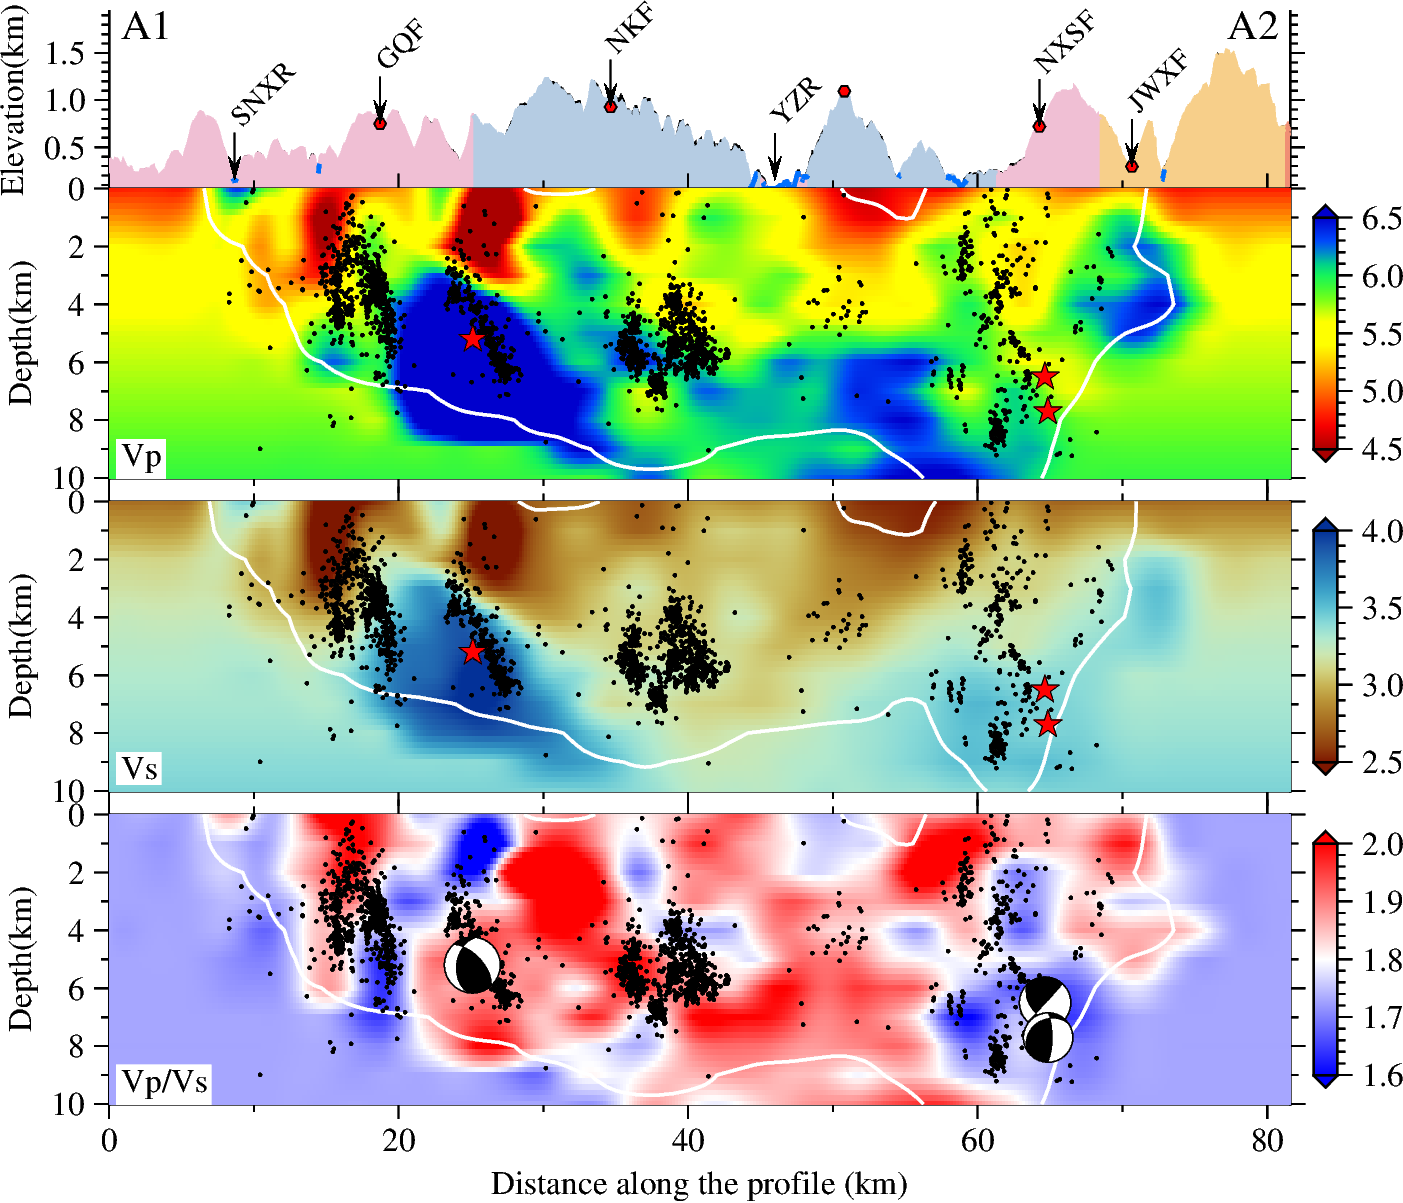

In [12]:
interval = 100
fig = pygmt.Figure()
pygmt.config(FONT='8p,4',MAP_FRAME_PEN='0.5p')
# profile A1A2
points,ele,vp,profile_region,profile = get_profile(model,topo,P_A,[0.2,0.2],wave='vp')
_,_,vs,_,_ = get_profile(model,topo,P_A,[0.2,0.2],wave='vs')
_,_,dwsp,_,_ = get_profile(model,topo,P_A,[0.2,0.2],wave='dwsp')
_,_,dwss,_,_ = get_profile(model,topo,P_A,[0.2,0.2],wave='dwss')

reloc,meca = project_data(catalog,cap,P_A,width=5)
map_width = 10 #cm
xscale = map_width/(profile_region[1]-profile_region[0])
zscale = xscale*2.0
map_height = (profile_region[3]-profile_region[2])*xscale
# region
region = pygmt.info(data=ele[['p','elevation']],per_column=True)
region = [profile_region[0],profile_region[1],region[2],region[3]*1.3]
fig.basemap(region=region,projection='X{}c/1.5c'.format(profile_region[1]*xscale),frame=['xaf','yaf+lElevation(km)','Wse'])
plot_line(fig,P_A,ele,profile_region,label=['A1','A2'],fault_label=label_A)
plot_meca(fig,meca,P_A)
fig.show()

In [13]:
lineB = [[29.679029,0.201606741,'SNXR',0,0.4],
         [72.577369,0.141759880,'XXR', 0,0.4],
         [41.241013,0.716621225,'GQF', 0,0.4],
         [52.468576,1.001709079,'NKF', 0,0.4],
         [67.970012,0.464552714,'XSF', 0,0.4]]
label_B = pd.DataFrame(lineB,columns=['x','y','name','dx','dy'])

x= 29.679029155223827 y= 0.20160674135226087 name= river color= 0/112/255
x= 32.06892310777872 y= 0.3107538909183636 name= river color= 0/112/255
x= 72.57736953397152 y= 0.14175988048364002 name= river color= 0/112/255
            x          y            z          p         q           r  \
4  110.440893  31.162353   716.621225  41.241013 -0.089075  110.440893   
3  110.558892  31.162353  1001.709079  52.468576 -0.085367  110.558893   
2  110.721808  31.162353   464.552714  67.970012 -0.060582  110.721809   
0  110.839790  31.162353   433.406542  79.195987 -0.028393  110.839791   
1  110.845125  31.162353   242.281177  79.703597 -0.026655  110.845126   

           s  
4  31.163154  
3  31.163121  
2  31.162898  
0  31.162608  
1  31.162593  


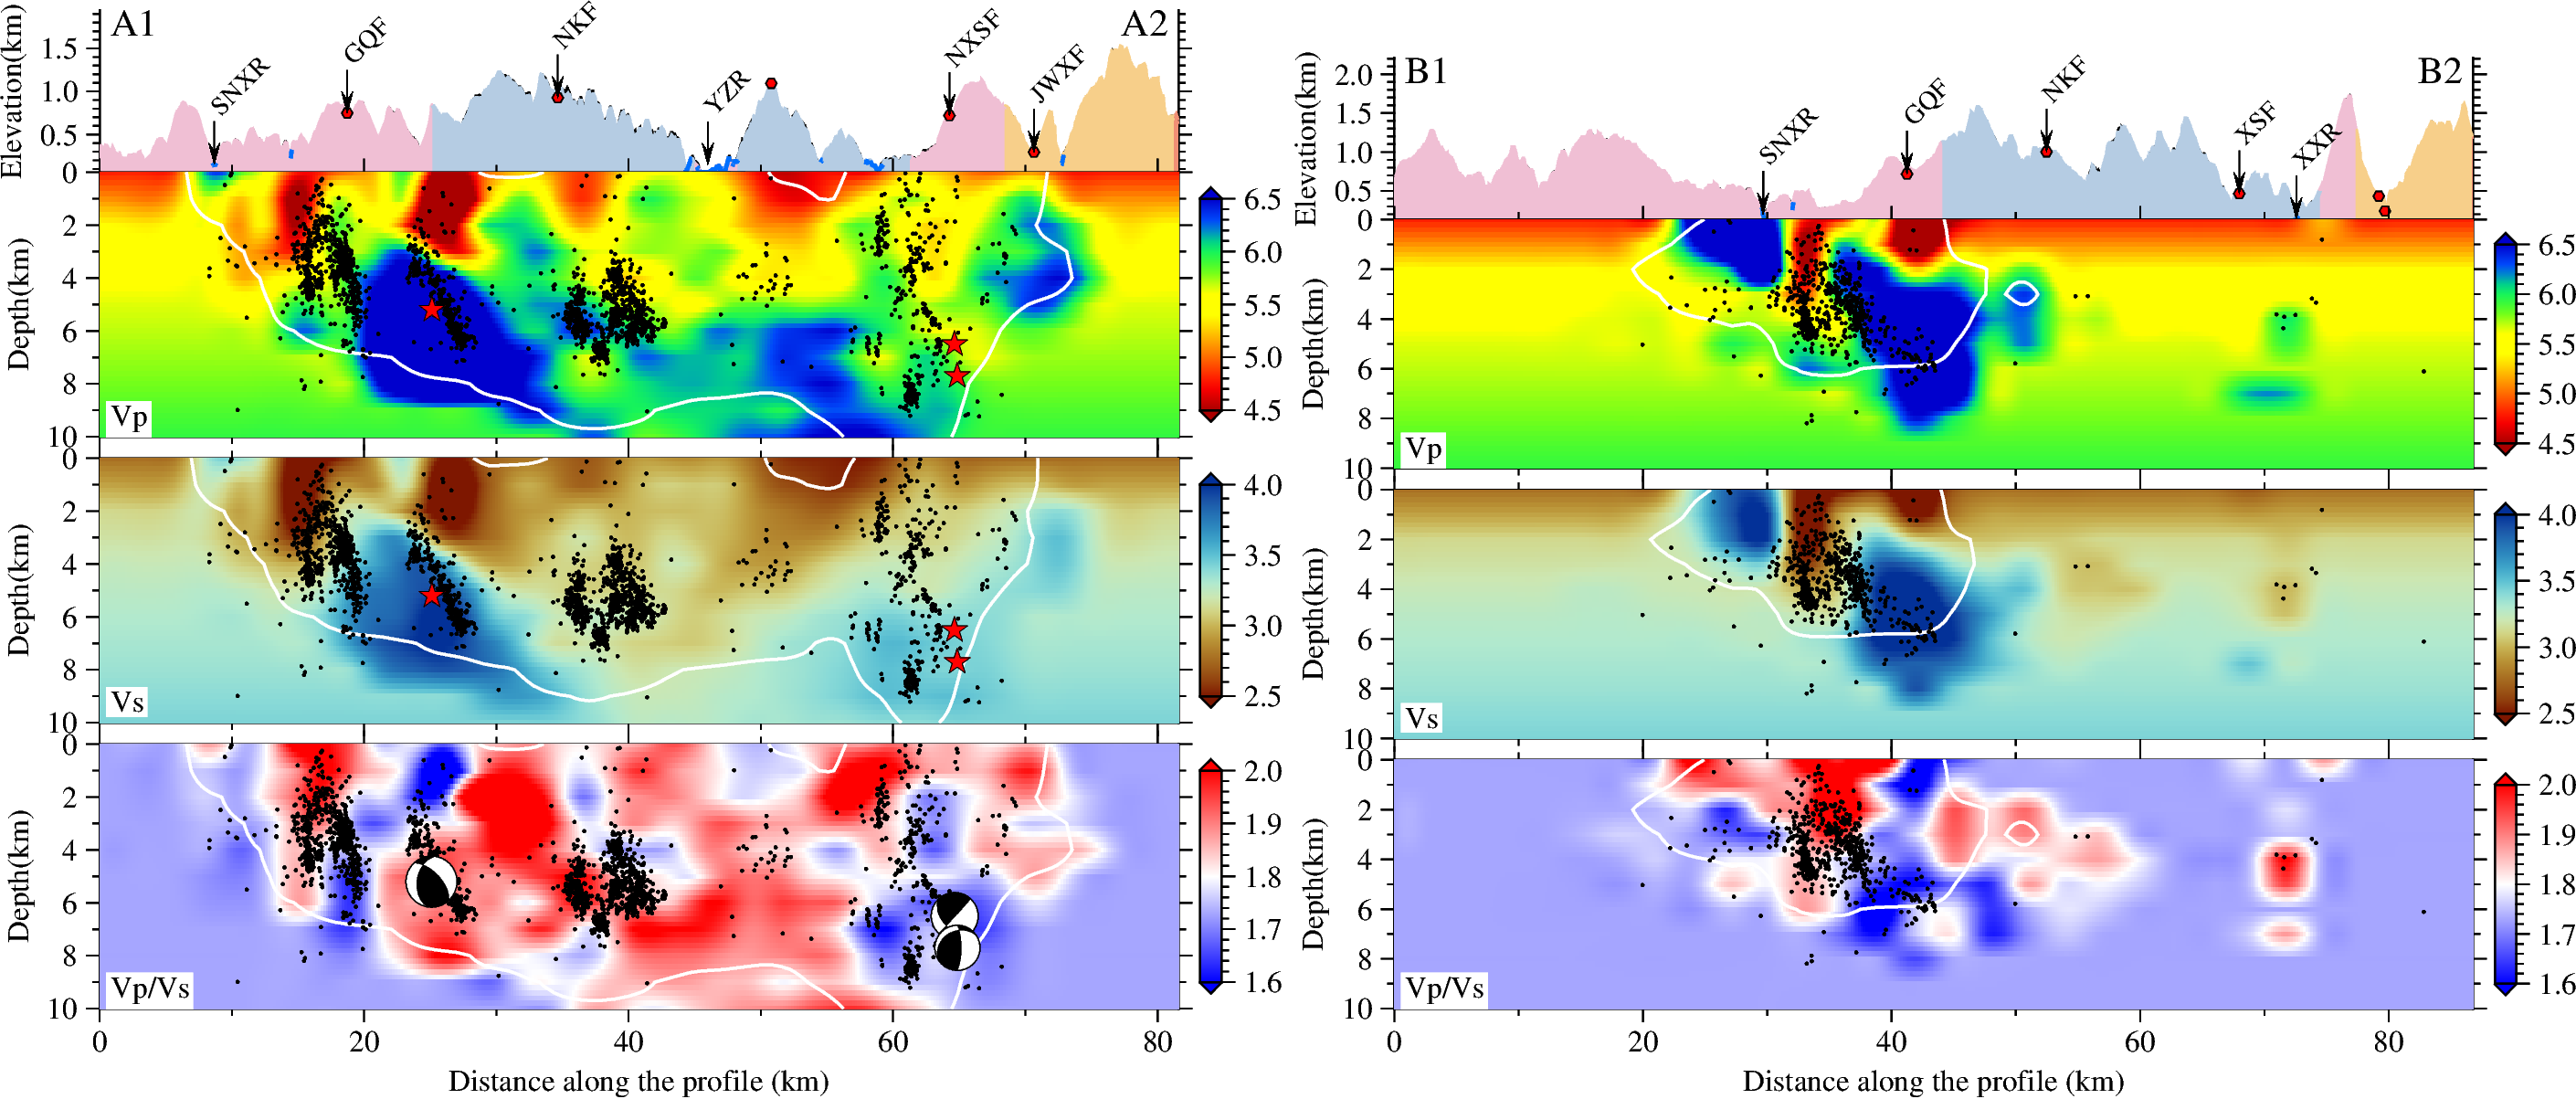

In [14]:
# profile B1B2
points,ele,vp,profile_region,profile = get_profile(model,topo,P_B,[0.2,0.2])
_,_,vs,_,_ = get_profile(model,topo,P_B,[0.2,0.2],wave='vs')
_,_,dwsp,_,_ = get_profile(model,topo,P_B,[0.2,0.2],wave='dwsp')
_,_,dwss,_,_ = get_profile(model,topo,P_B,[0.2,0.2],wave='dwss')
reloc,meca = project_data(catalog,cap,P_B,width=3)

xscale = map_width/(profile_region[1]-profile_region[0])
zscale = xscale*2.0
map_height = (profile_region[3]-profile_region[2])*xscale
# region
region = pygmt.info(data=ele[['p','elevation']],per_column=True)
region = [profile_region[0],profile_region[1],region[2],region[3]*1.3]

fig.shift_origin(xshift='12c',yshift='{}c'.format((map_height*zscale/xscale+0.2)*3-0.2))
fig.basemap(region=region,projection='X{}c/1.5c'.format(profile_region[1]*xscale),frame=['xaf','yaf+lElevation(km)','Wse'])
plot_line(fig,P_B,ele,profile_region,label=['B1','B2'],fault_label=label_B)
fig.show()

In [15]:
lineC = [[30.598951,0.342014874,'GQF',0,0.4],
         [50.137460,0.985685102,'NKF',0,0.4],
         [64.918690,0.267026603,'XSF',0,0.4],
         [72.441453,0.156441,'XXR',0,0.4]]
label_C = pd.DataFrame(lineC,columns=['x','y','name','dx','dy'])

x= 29.528004247953838 y= 0.14608882622176803 name= river color= 0/112/255
x= 37.82444519621408 y= 0.16464907891753844 name= river color= 0/112/255
x= 72.44145378209876 y= 0.15644178200568645 name= river color= 0/112/255
            x          y            z          p         q           r  \
5  110.120134  31.081176   548.151653  10.710134 -0.038547  110.120133   
4  110.328982  31.081176   342.014874  30.598951 -0.081338  110.328980   
3  110.534150  31.081176   985.685102  50.137460 -0.086932  110.534151   
2  110.689364  31.081176   267.026603  64.918690 -0.067164  110.689365   
0  110.847058  31.081176   819.195126  79.936121 -0.025910  110.847059   
1  110.867899  31.081176  1129.525372  81.920786 -0.018862  110.867900   

           s  
5  31.081523  
4  31.081908  
3  31.081958  
2  31.081781  
0  31.081410  
1  31.081346  


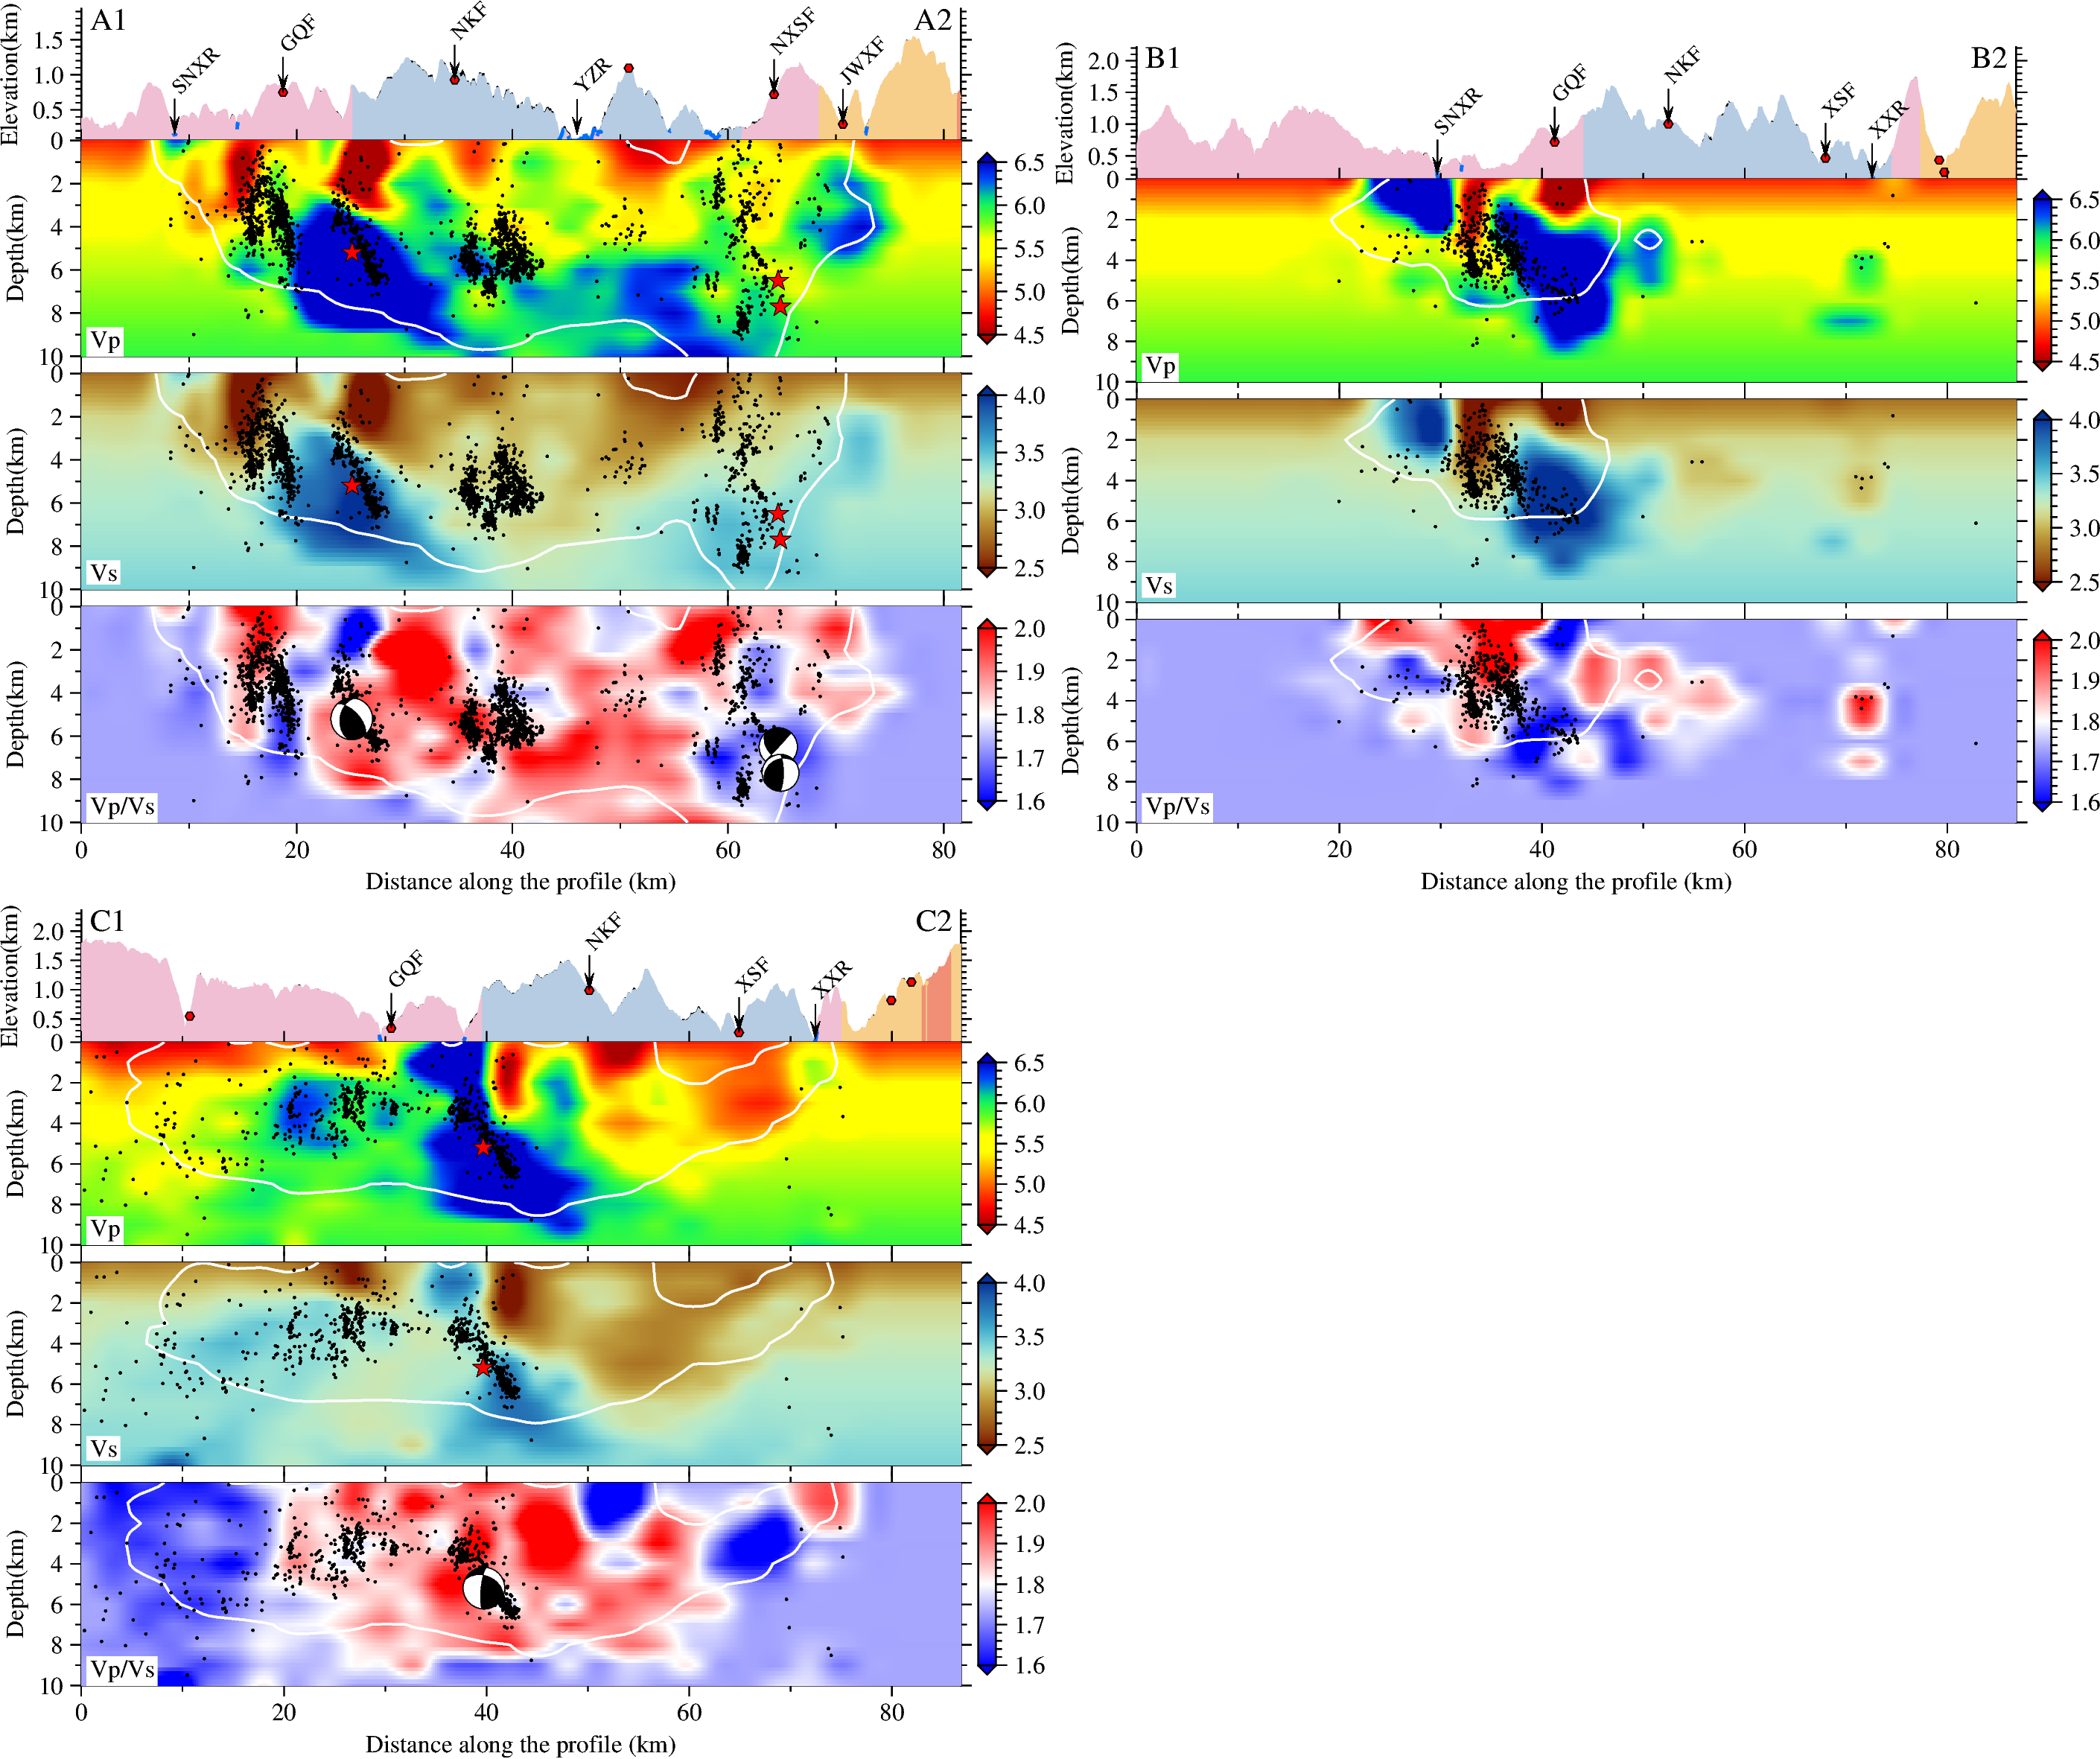

In [16]:
# profile C1C2
points,ele,vp,profile_region,profile = get_profile(model,topo,P_C,[0.2,0.2])
_,_,vs,_,_ = get_profile(model,topo,P_C,[0.2,0.2],wave='vs')
_,_,dwsp,_,_ = get_profile(model,topo,P_C,[0.2,0.2],wave='dwsp')
_,_,dwss,_,_ = get_profile(model,topo,P_C,[0.2,0.2],wave='dwss')
reloc,meca = project_data(catalog,cap,P_C,width=3)

xscale = map_width/(profile_region[1]-profile_region[0])
zscale = xscale*2.0
map_height = (profile_region[3]-profile_region[2])*xscale
# region
region = pygmt.info(data=ele[['p','elevation']],per_column=True)
region = [profile_region[0],profile_region[1],region[2],region[3]*1.3]

fig.shift_origin(xshift='-12c',yshift='-{}c'.format(2.5))
fig.basemap(region=region,projection='X{}c/1.5c'.format(profile_region[1]*xscale),frame=['xaf','yaf+lElevation(km)','Wse'])
plot_line(fig,P_C,ele,profile_region,label=['C1','C2'],fault_label=label_C)
plot_meca(fig,meca,P_C)
fig.show()

In [17]:
lineD = [[47.399612,0.2461926,'NKF', 0,0.4],
         [41.668785,0.1043065,'YZR', 0,0.4],
         [65.515675,0.1827723,'STBR',0,0.4],
         [71.257675,0.1086118,'XXR', 0,0.4]]
label_D = pd.DataFrame(lineD,columns=['x','y','name','dx','dy'])

x= 7.225951824085893 y= 0.061953208837117864 name= river color= 0/112/255
x= 7.462008004510126 y= 0.062012001703525 name= river color= 0/112/255
x= 8.224983996958803 y= 0.14277169392234013 name= river color= 0/112/255
x= 9.142944694541812 y= 0.187986634830625 name= river color= 0/112/255
x= 15.051746078187094 y= 0.20132403144319044 name= river color= 0/112/255
x= 18.08579788873459 y= 0.0946875250961188 name= river color= 0/112/255
x= 28.1516825650156 y= 0.11271162572020002 name= river color= 0/112/255
x= 38.72988956049129 y= 0.2913829185043809 name= river color= 0/112/255
x= 38.944279072091284 y= 0.29254797384214287 name= river color= 0/112/255
x= 39.08372470623036 y= 0.2858314593585 name= river color= 0/112/255
x= 39.334604448330126 y= 0.24117505956175 name= river color= 0/112/255
x= 41.668785804583884 y= 0.10430657751978634 name= river color= 0/112/255
x= 44.00352909402428 y= 0.3195770541145 name= river color= 0/112/255
x= 50.99620296998353 y= 0.10125908808179403 name= river color= 0

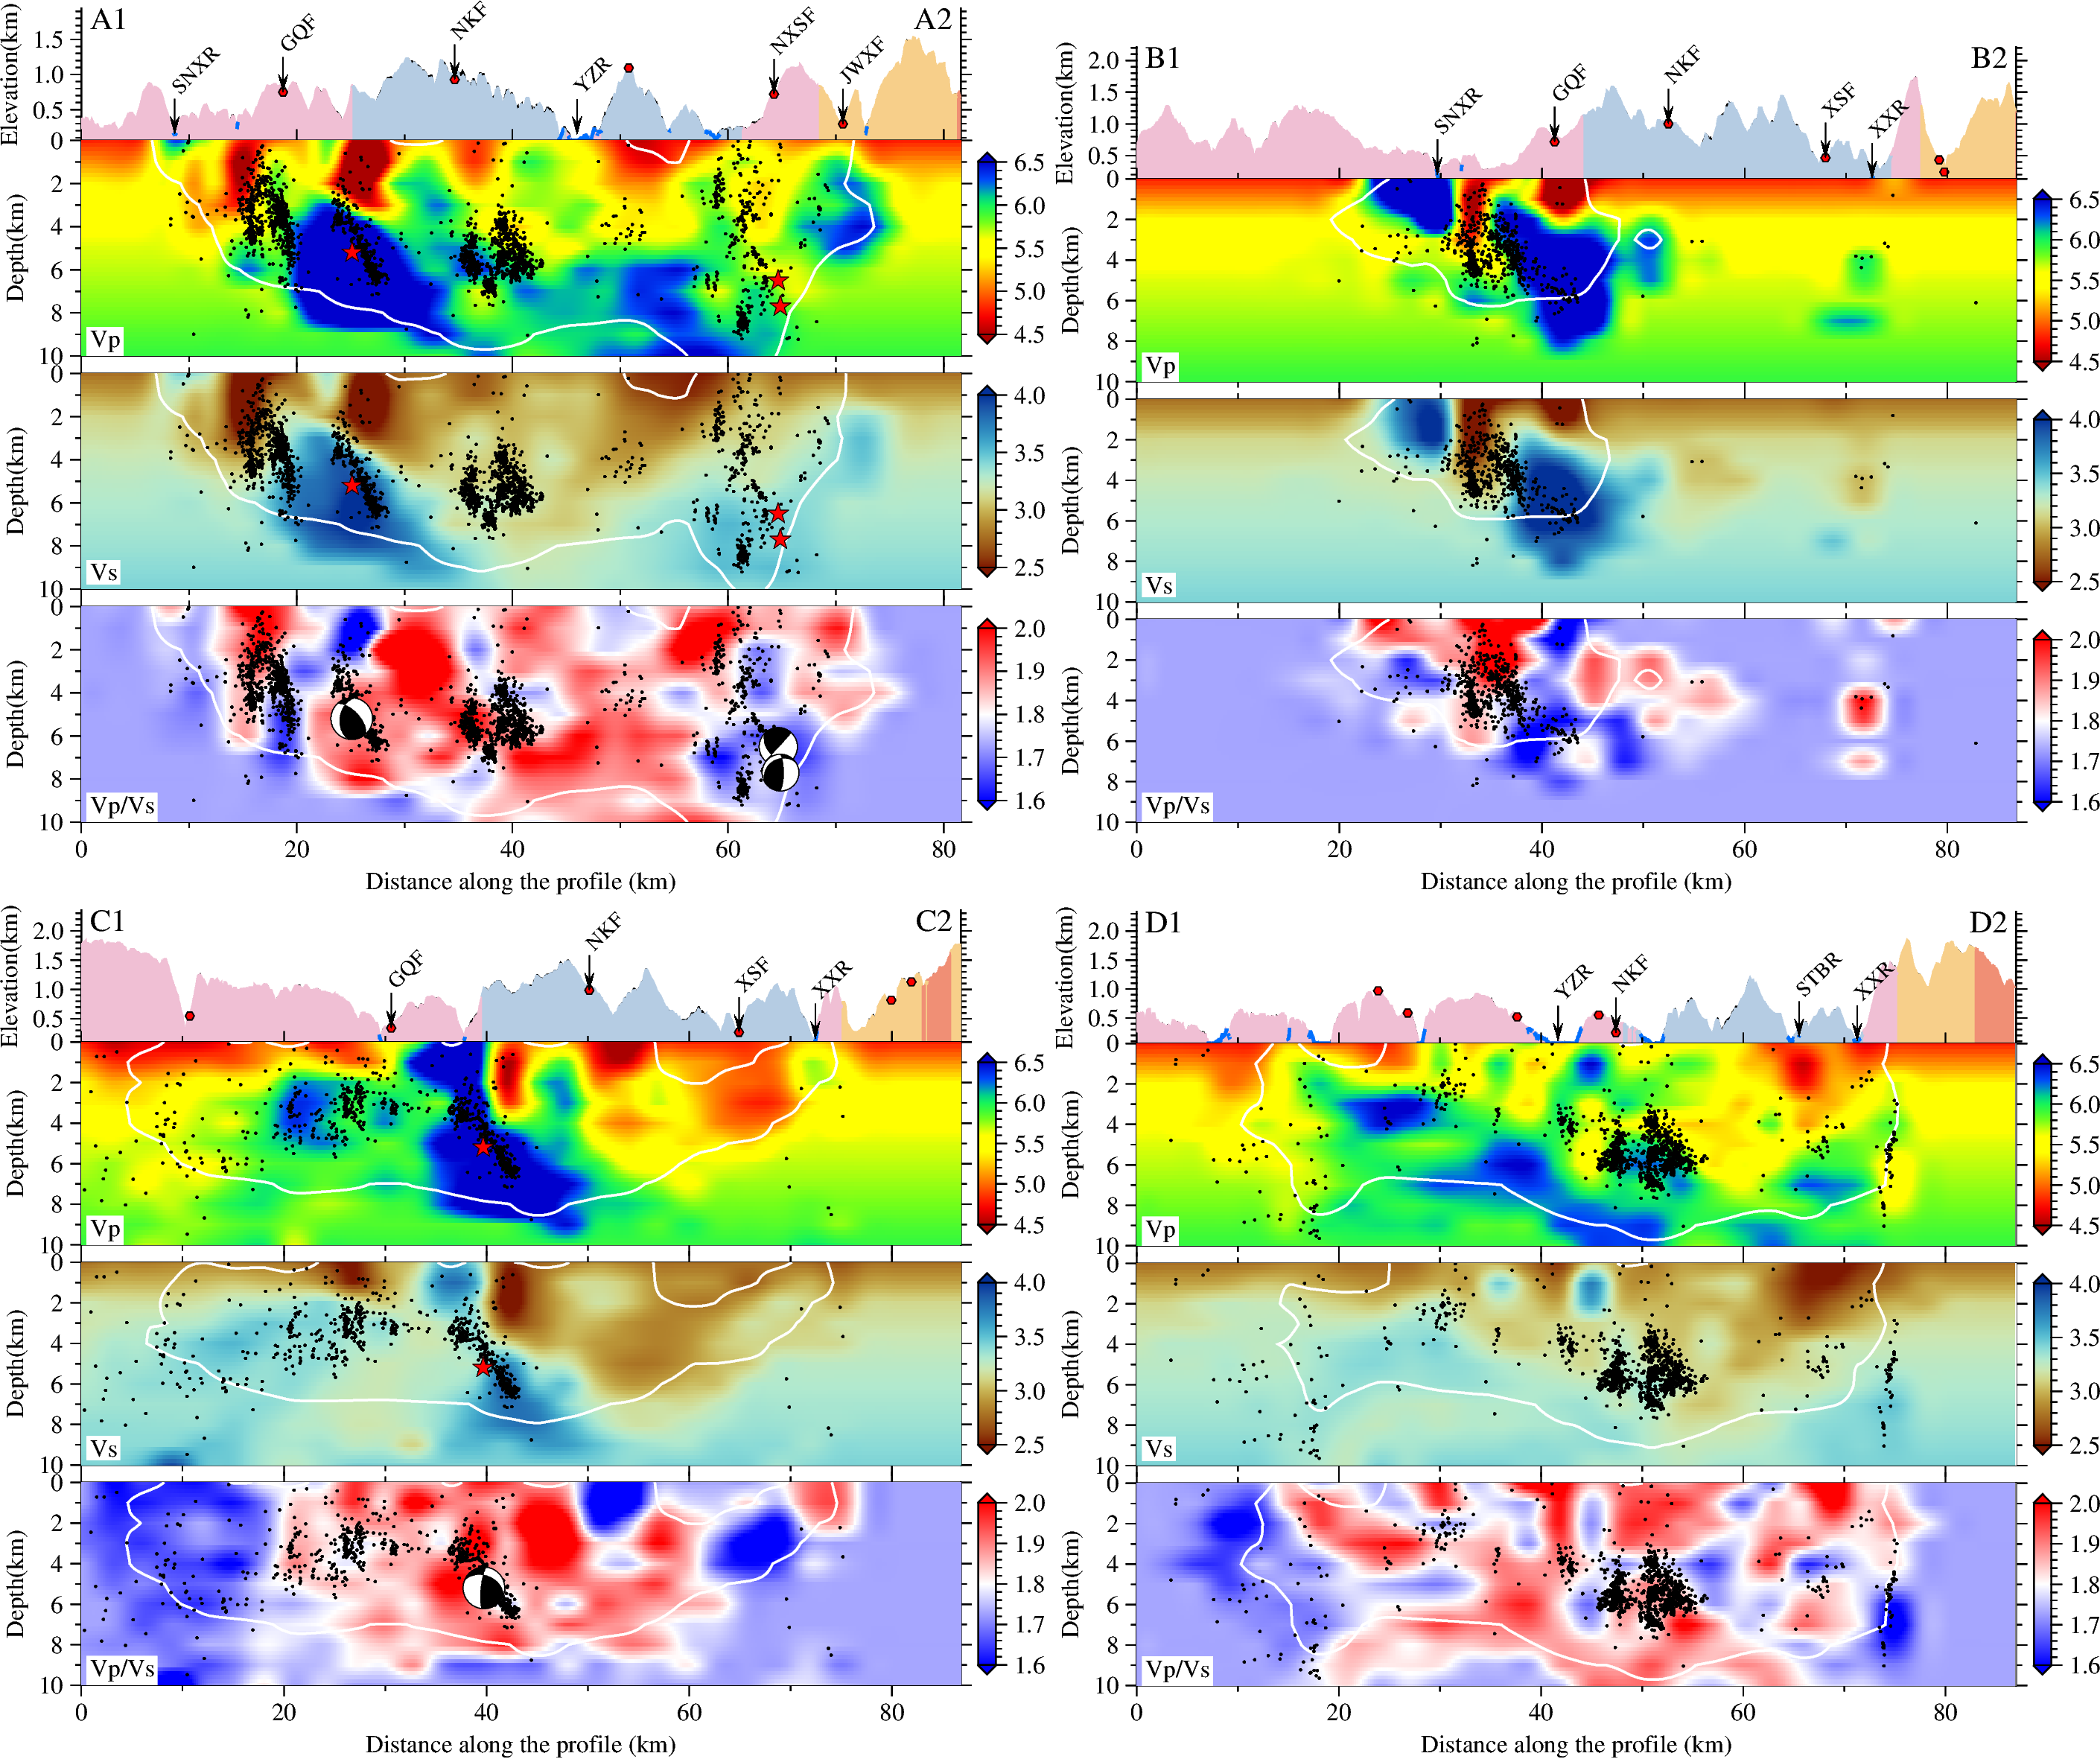

In [18]:
# profile D1D2
points,ele,vp,profile_region,profile = get_profile(model,topo,P_D,[0.2,0.2])
_,_,vs,_,_ = get_profile(model,topo,P_D,[0.2,0.2],wave='vs')
_,_,dwsp,_,_ = get_profile(model,topo,P_D,[0.2,0.2],wave='dwsp')
_,_,dwss,_,_ = get_profile(model,topo,P_D,[0.2,0.2],wave='dwss')
reloc,meca = project_data(catalog,cap,P_D,width=3)

xscale = map_width/(profile_region[1]-profile_region[0])
zscale = xscale*2.0
map_height = (profile_region[3]-profile_region[2])*xscale

# region
region = pygmt.info(data=ele[['p','elevation']],per_column=True)
region = [profile_region[0],profile_region[1],region[2],region[3]*1.3]

fig.shift_origin(xshift='12c',yshift='{}c'.format((map_height*zscale/xscale+0.2)*3-0.2))
fig.basemap(region=region,projection='X{}c/1.5c'.format(profile_region[1]*xscale),frame=['xaf','yaf+lElevation(km)','Wse'])
plot_line(fig,P_D,ele,profile_region,label=['D1','D2'],fault_label=label_D)
fig.show()

In [19]:
# profile E1E2
"""
points,ele,vp,profile_region,profile = get_profile(model,topo,P_E,[0.2,0.2])
_,_,vs,_,_ = get_profile(model,topo,P_E,[0.2,0.2],wave='vs')
reloc,meca = project_data(catalog,cap,P_E,width=3)

xscale = 0.5*map_width/(profile_region[1]-profile_region[0])
zscale = xscale*1.5
map_height = (profile_region[3]-profile_region[2])*xscale

# region
region = pygmt.info(data=ele[['p','elevation']],per_column=True)
region = [profile_region[0],profile_region[1],region[2],region[3]*1.3]

fig.shift_origin(xshift='-12c',yshift='-{}c'.format(2.5))
fig.basemap(region=region,projection='X{}c/1.5c'.format(profile_region[1]*xscale),frame=['xaf','yaf+lElevation(km)','Wse'])
plot_line(fig,P_E,ele,profile_region,label=['E1','E2'])
fig.show()
"""

"\npoints,ele,vp,profile_region,profile = get_profile(model,topo,P_E,[0.2,0.2])\n_,_,vs,_,_ = get_profile(model,topo,P_E,[0.2,0.2],wave='vs')\nreloc,meca = project_data(catalog,cap,P_E,width=3)\n\nxscale = 0.5*map_width/(profile_region[1]-profile_region[0])\nzscale = xscale*1.5\nmap_height = (profile_region[3]-profile_region[2])*xscale\n\n# region\nregion = pygmt.info(data=ele[['p','elevation']],per_column=True)\nregion = [profile_region[0],profile_region[1],region[2],region[3]*1.3]\n\nfig.shift_origin(xshift='-12c',yshift='-{}c'.format(2.5))\nfig.basemap(region=region,projection='X{}c/1.5c'.format(profile_region[1]*xscale),frame=['xaf','yaf+lElevation(km)','Wse'])\nplot_line(fig,P_E,ele,profile_region,label=['E1','E2'])\nfig.show()\n"

In [20]:
fig.savefig('plotting_figures'+os.sep+'Figure13_profile.png',dpi=600)
fig.savefig('plotting_figures'+os.sep+'Figure13_profile.pdf')

In [21]:
for file in glob.glob('*.cpt'):
    os.remove(file)